In [5]:
import pandas as pd
import os
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from xgboost import  XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_error
import pickle
import findspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import col, lit, concat_ws, collect_set
from pyspark.sql.types import TimestampType, StructField, StringType, IntegerType, StructType
from pyspark.sql.functions import date_format
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.regression import LinearRegression
from sklearn.linear_model import LinearRegression
from pyspark.sql.functions import lit
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql import functions as F
from sklearn.neighbors import KNeighborsRegressor

In [6]:
findspark.init()
findspark.find()
# Importar las bibliotecas necesarias
sc = SparkContext.getOrCreate()
# Primera sesión de Spark
spark = SparkSession.builder \
    .appName("Trufi") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.driver.host", "localhost") \
    .config("spark.master", "local") \
    .getOrCreate()

# Configurar el número de particiones
spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.sparkContext

<SparkContext master=local[*] appName=pyspark-shell>

In [7]:
# Obtener la ruta de la carpeta del notebook
notebook_folder = os.getcwd()
root_project = os.path.abspath(os.path.join(notebook_folder, '..'))
dataset_logs = os.path.abspath(os.path.join(root_project, 'Datos', 'Logs'))
trufi_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App'))
h3_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App','id_index_h3.csv'))
temporal_serie_data = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App','temporal_serie_data'))
csv_file_path = os.path.join(trufi_datos, 'origen-destino.csv')

In [8]:
# Lee el archivo CSV en un DataFrame
dfSpark = spark.read.csv("file:///" + temporal_serie_data, header=True, inferSchema=True)
df = dfSpark.withColumn('hourly_timestamp', F.date_format('hourly_timestamp', 'yyyy-MM-dd HH:mm:ss'))
df = df.toPandas()
# Convierte la columna 'hourly_timestamp' a formato de fecha en pandas
df['hourly_timestamp'] = pd.to_datetime(df['hourly_timestamp'])

In [9]:
# Tu lista de ubicaciones principales
top_locations = ['1', '2', '3', '4', '10']

# Filtrar las filas donde 'OriginLocationID' no está en la lista top_locations
# filtered_df = df[~df['OriginLocationID'].isin(top_locations)]
filtered_df = df
filtered_df.head(20)

,hourly_timestamp,origin_request_count,LocationID,destination_request_count,Holiday_n,windspeed,cloudcover,precip,humidity,temp,fin_de_semana,dia_de_semana,hora,dia_de_mes,mes,anio,h3_index,id,latitude,longitude
0,2023-05-02 08:00:00,0.0,92.0,0.0,0.0,5.4,27.5,0.0,66.88,14.9,0.0,3.0,8.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787
1,2023-05-02 09:00:00,0.0,92.0,0.0,0.0,5.4,27.5,0.0,52.28,19.0,0.0,3.0,9.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787
2,2023-05-02 10:00:00,0.0,92.0,0.0,0.0,5.4,27.5,0.0,40.60,22.0,0.0,3.0,10.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787
3,2023-05-02 11:00:00,0.0,92.0,0.0,0.0,7.6,17.4,0.0,40.58,22.9,0.0,3.0,11.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787
4,2023-05-02 12:00:00,0.0,92.0,0.0,0.0,7.6,27.5,0.0,31.93,26.0,0.0,3.0,12.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787
5,2023-05-02 13:00:00,0.0,92.0,0.0,0.0,11.2,27.5,0.0,28.12,27.0,0.0,3.0,13.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787
6,2023-05-02 14:00:00,0.0,92.0,0.0,0.0,9.4,55.1,0.0,23.45,27.8,0.0,3.0,14.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787
7,2023-05-02 15:00:00,0.0,92.0,0.0,0.0,18.4,50.0,0.0,21.54,28.0,0.0,3.0,15.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787
8,2023-05-02 16:00:00,0.0,92.0,0.0,0.0,25.9,50.0,0.0,18.70,28.0,0.0,3.0,16.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787
9,2023-05-02 17:00:00,0.0,92.0,0.0,0.0,18.4,55.1,0.0,20.16,26.9,0.0,3.0,17.0,2.0,5.0,2023.0,878b2c8b5ffffff,92,-17.410628,-66.110787


In [10]:
def split_data(X,y):
    valSize = 0.25 #0.8 * 0.2 = 0.2
    testSize = 0.2

    # Split TRAIN-TEST
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # Split TRAIN-VALIDATION
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valSize, random_state=1)
    
    
    print('X_train: {0} ({1}%)'.format(X_train.shape[0], (X_train.shape[0]/X.shape[0])*100))
    print('y_train: {0} ({1}%)'.format(y_train.shape[0], (y_train.shape[0]/X.shape[0])*100))

    print('X_val: {0} ({1}%)'.format(X_val.shape[0], (X_val.shape[0]/X.shape[0])*100))
    print('y_val: {0} ({1}%)'.format(y_val.shape[0], (y_val.shape[0]/X.shape[0])*100))

    print('X_test: {0} ({1}%)'.format(X_test.shape[0], (X_test.shape[0]/X.shape[0])*100))
    print('y_test: {0} ({1}%)'.format(y_test.shape[0], (y_test.shape[0]/X.shape[0])*100))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def plot_real_vs_pred(model_name, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(40)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(16,5))
    plt.show()
    
def get_metrics(model_name, y_real, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # MAE: same units as target variable. It is more robust to outliers
    MAE = mean_absolute_error(y_real, y_pred)

    # RMSE: same units as target variable
    RMSE = np.sqrt(mean_squared_error(y_real, y_pred))
    
    # R^2
    R2 = r2_score(y_real, y_pred)
    
    # Correlation
    R = np.corrcoef(y_real, y_pred)[0][1]
    
    print('MODEL: ', model_name)
    print('MAE: ', MAE)
    print('RMSE: ', RMSE)
    print('R^2 (Coefficient of determination): ', R2)
    print('R (Correlation coefficient): ', R)
    
    return model_name, MAE, RMSE, R2, R

def basemodel_predict(base, X_val):
    # select columns of interest to use to get values from basemodel
    X_val = X_val[['hora', 'LocationID']]
    #X_val = X_val.head(10)
    output = [
        
    ]
    
    # map average values from baseline model with validation data
    # append those values to output series
    for index, row in X_val.iterrows():
        output.append(int(base.loc[(row['hora'], row['LocationID']), :]))

    output_array = np.asarray(output)
    return output_array

def compare_model_metrics(mod_metric_list):
    plt.style.use('ggplot')
    
    # Create DataFrames with metric data
    df_MAE = pd.DataFrame({'Model': [mod[0] for mod in mod_metric_list], 'MAE': [mod[1] for mod in mod_metric_list]})
    df_RMSE = pd.DataFrame({'Model': [mod[0] for mod in mod_metric_list], 'RMSE': [mod[2] for mod in mod_metric_list]})
    df_R2 = pd.DataFrame({'Model': [mod[0] for mod in mod_metric_list], 'R2': [mod[3] for mod in mod_metric_list]})
    df_R = pd.DataFrame({'Model': [mod[0] for mod in mod_metric_list], 'R (Correlation)': [mod[4] for mod in mod_metric_list]})

    # Sort values so the best model appears first
    df_MAE = df_MAE.sort_values('MAE', ascending=False)
    df_RMSE = df_RMSE.sort_values('RMSE', ascending=False)
    df_R2 = df_R2.sort_values('R2', ascending=True)
    df_R = df_R.sort_values('R (Correlation)', ascending=True)

    # Create figure and one axis per metric
    f = plt.figure(figsize=(8, len(mod_metric_list) * 3))
    axes1 = f.add_subplot(4, 1, 1)
    axes2 = f.add_subplot(4, 1, 2)
    axes3 = f.add_subplot(4, 1, 3)
    axes4 = f.add_subplot(4, 1, 4)

    # Plot dataframes with Seaborn
    sns.barplot(x='MAE', y='Model', data=df_MAE, ax=axes1, color='lightcoral')\
        .legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
    sns.barplot(x='RMSE', y='Model', data=df_RMSE, ax=axes2, color='cornflowerblue')\
        .legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
    sns.barplot(x='R2', y='Model', data=df_R2, ax=axes3, color='goldenrod')\
        .legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
    sns.barplot(x='R (Correlation)', y='Model', data=df_R, ax=axes4, color='mediumseagreen')\
        .legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

    # Annotate bars with result values
    for p in axes1.patches:
        axes1.annotate(np.round(a=p.get_width(), decimals=1), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 5),
                       textcoords='offset points')

    for p in axes2.patches:
        axes2.annotate(np.round(a=p.get_width(), decimals=1), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 5),
                       textcoords='offset points')

    for p in axes3.patches:
        axes3.annotate(np.round(a=p.get_width(), decimals=3), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 5),
                       textcoords='offset points')

    for p in axes4.patches:
        axes4.annotate(np.round(a=p.get_width(), decimals=3), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 5),
                       textcoords='offset points')

    plt.show()


In [12]:
# Separate variables
X = filtered_df[['LocationID','hora','fin_de_semana','Holiday_n','temp']]
y = filtered_df['origin_request_count']
print("FEATURES 'X' should be a Pandas DataFrame: ", type(X)) # 'X' must be DataFrame and 'y' must be a Pandas Series
display(X.head(2))
print("TARGET VARIABLE 'y' should be a Pandas Series: ",type(y))
display(y.head(2))

FEATURES 'X' should be a Pandas DataFrame:  <class 'pandas.core.frame.DataFrame'>


,LocationID,hora,fin_de_semana,Holiday_n,temp
0,92.0,8.0,0.0,0.0,14.9
1,92.0,9.0,0.0,0.0,19.0


TARGET VARIABLE 'y' should be a Pandas Series:  <class 'pandas.core.series.Series'>


0    0.0
1    0.0
Name: origin_request_count, dtype: float64

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

X_train: 829209 (59.99995658516255%)
y_train: 829209 (59.99995658516255%)
X_val: 276403 (19.999985528387516%)
y_val: 276403 (19.999985528387516%)
X_test: 276404 (20.00005788644994%)
y_test: 276404 (20.00005788644994%)


In [15]:
# select columns of interest from dataset
basemodel = df[['hora', 'LocationID', 'origin_request_count']]

# groupby and calculate pickups average
basemodel = basemodel.groupby(['hora', 'LocationID']).mean()
basemodel.sample(5)

,,origin_request_count
hora,LocationID,
18.0,107.0,0.000000
1.0,97.0,0.000000
9.0,39.0,0.000000
0.0,109.0,0.000000
13.0,30.0,0.008475


In [16]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [17]:
%%time
base_y_pred = basemodel_predict(basemodel, X_val)

CPU times: total: 2min 7s
Wall time: 2min 50s


MODEL:  Baseline Model
MAE:  0.008549111261455194
RMSE:  0.3154757819175004
R^2 (Coefficient of determination):  -0.0007349011615584988
R (Correlation coefficient):  nan


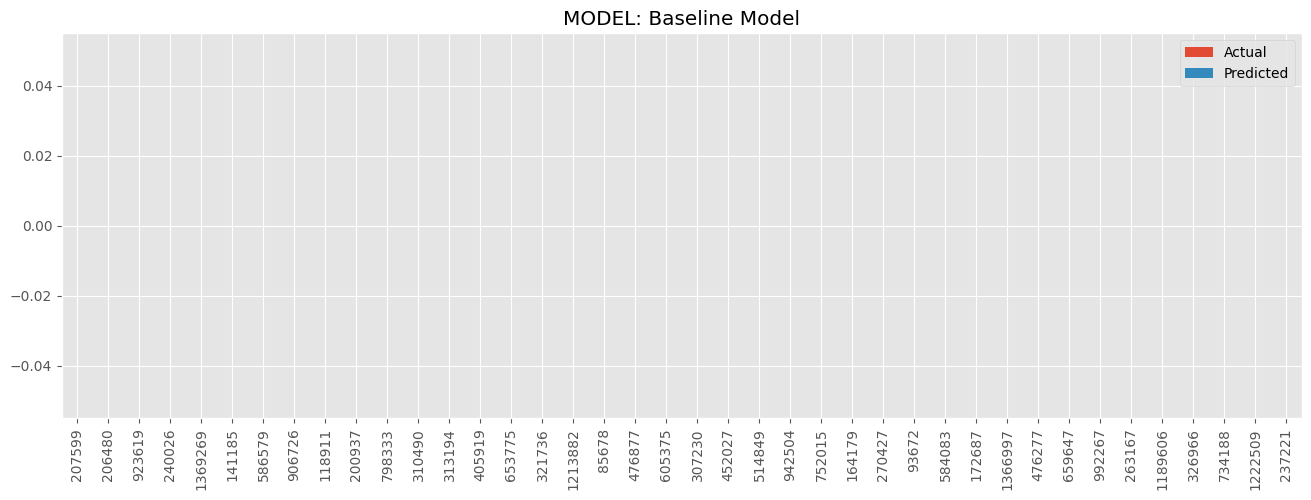

Text(0.5, 1.0, 'Baseline model: Actual vs Predicted')

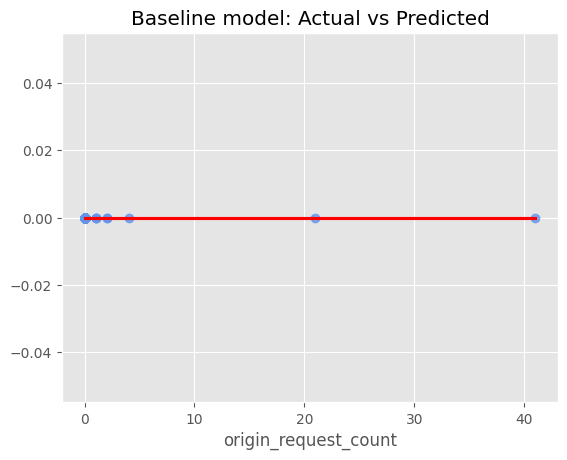

In [18]:
base_metrics = get_metrics('Baseline Model',y_val, base_y_pred)

plot_real_vs_pred('Baseline Model', y_val, base_y_pred)

sns.regplot(x=y_val.head(5000), y=base_y_pred[:5000],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline model: Actual vs Predicted')

In [19]:
# Create an instance of the model and train it
reg = LinearRegression()

reg.fit(X_train, y_train)

# Do predictions
reg_y_pred = reg.predict(X_val)

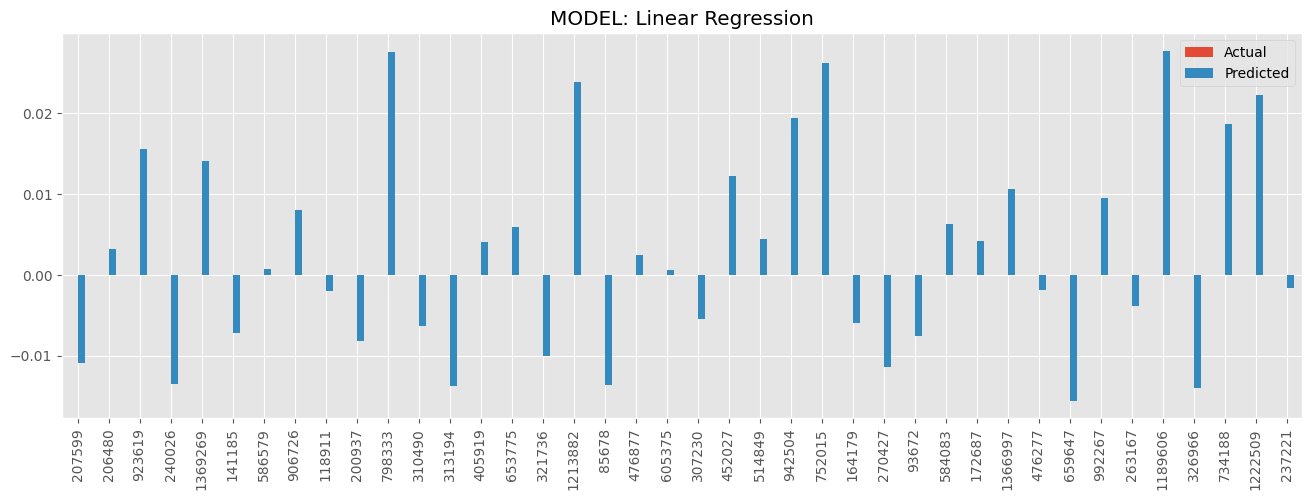

Text(0.5, 1.0, 'Linear Regression: Actual vs Predicted')

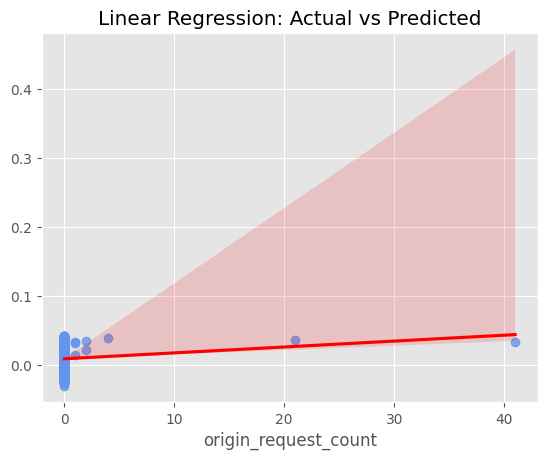

In [20]:
plot_real_vs_pred('Linear Regression', y_val, reg_y_pred)

sns.regplot(x=y_val.head(5000), y=reg_y_pred[:5000],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression: Actual vs Predicted')

MODEL:  Linear Regression
MAE:  0.021771990928078116
RMSE:  0.3150938880389962
R^2 (Coefficient of determination):  0.0016864778297245309
R (Correlation coefficient):  0.041137817554879004


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


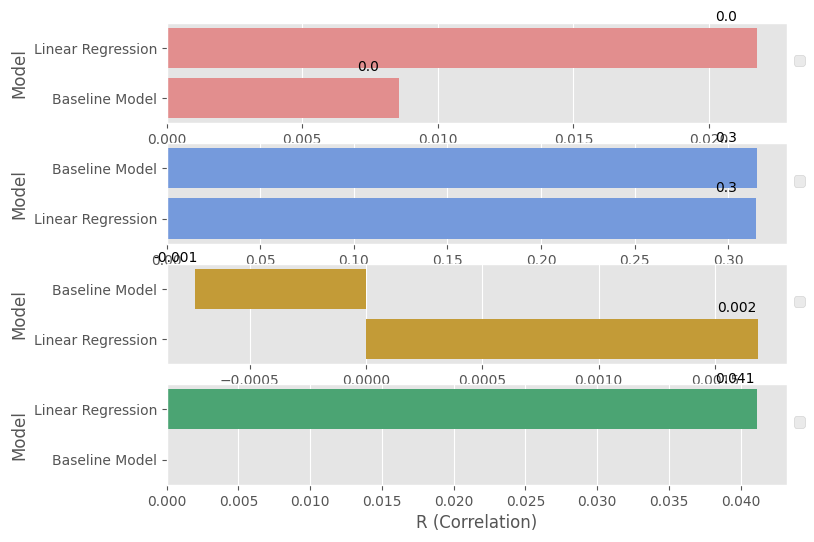

In [21]:
reg_metrics = get_metrics('Linear Regression',y_val, reg_y_pred)
compare_model_metrics([base_metrics,
                       reg_metrics])

In [22]:
# Create an instance.
regk = KNeighborsRegressor(n_neighbors=2, weights = 'uniform')

# Train the data
regk.fit(X_train, y_train)

# Do predictions
regk_y_pred = regk.predict(X_val)

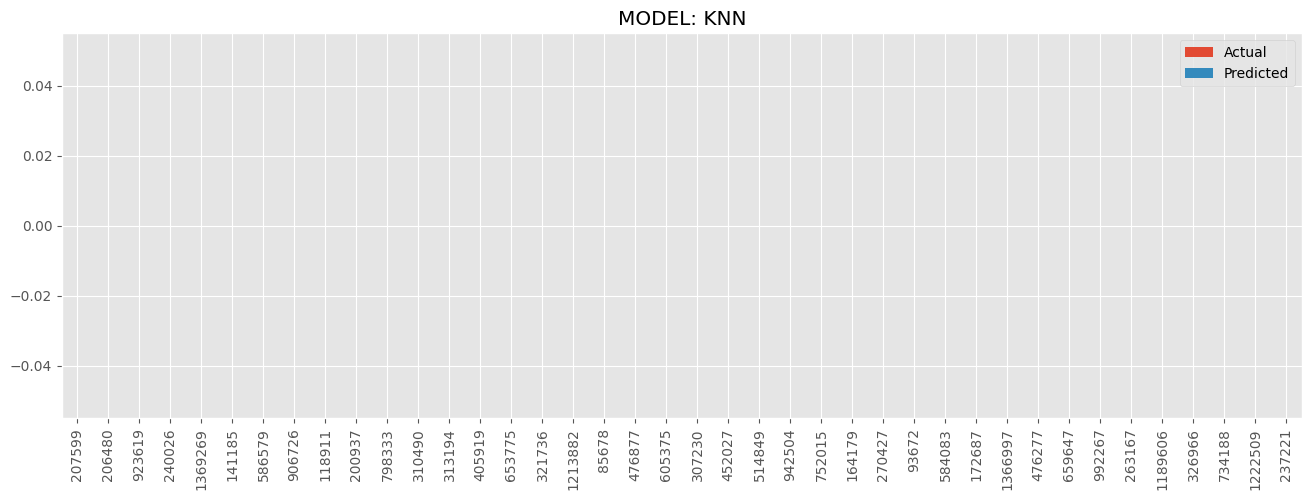

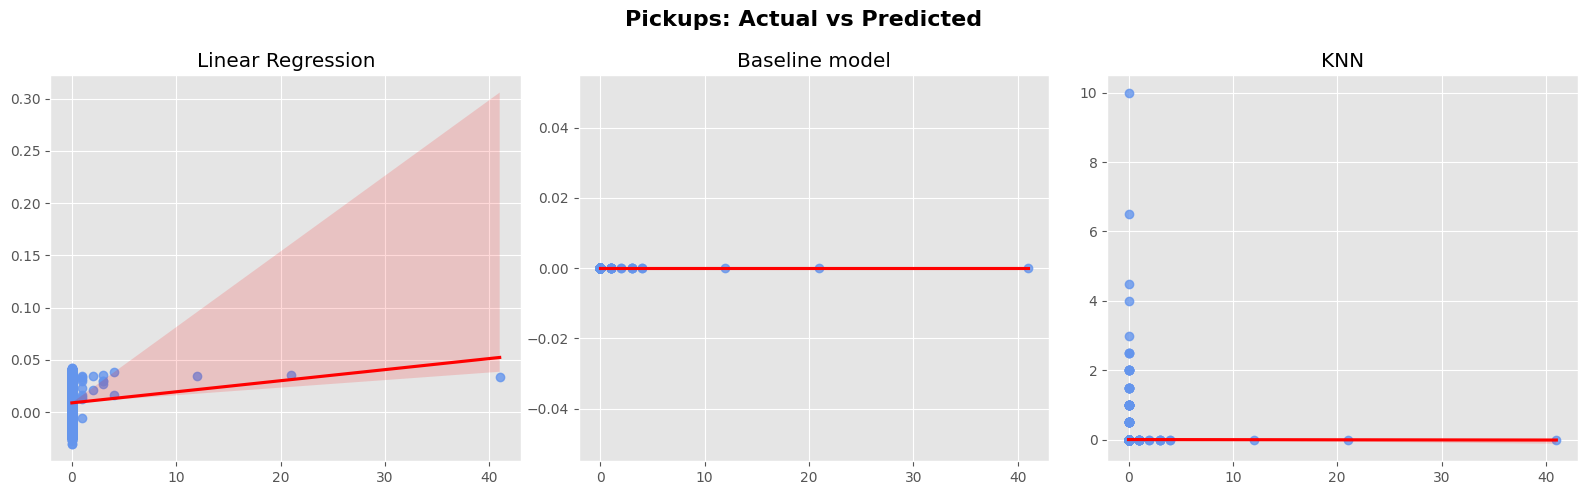

In [23]:
plot_real_vs_pred('KNN', y_val, regk_y_pred)

fig, ax =plt.subplots(1,3,figsize=(16,5))
fig.suptitle('Pickups: Actual vs Predicted', fontsize=16, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.85)

sns.regplot(x=y_val.head(10000), y=reg_y_pred[:10000],ax=ax[0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression')
sns.regplot(x=y_val.head(10000), y=base_y_pred[:10000],  ax=ax[1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline model')
sns.regplot(x=y_val.head(10000), y=regk_y_pred[:10000],  ax=ax[2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN')


for column in ax:
        column.set_xlabel("")
        column.set_ylabel("")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MODEL:  KNN
MAE:  0.017114503098736265
RMSE:  0.3808044030175138
R^2 (Coefficient of determination):  -0.458112113295005
R (Correlation coefficient):  0.05148910790891469


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


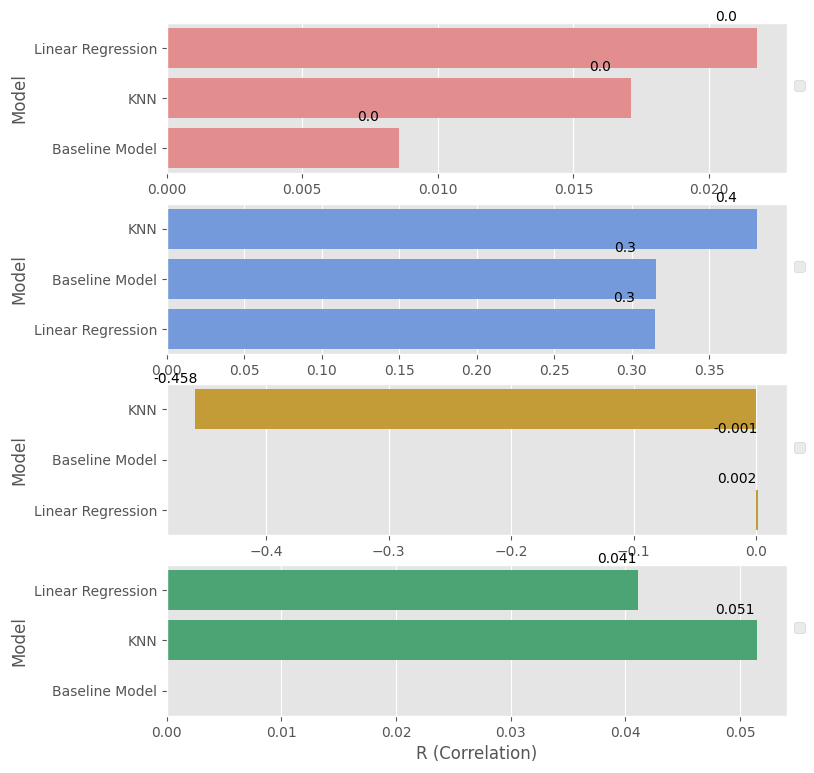

In [24]:
regk_metrics = get_metrics('KNN',y_val, regk_y_pred)

compare_model_metrics([base_metrics,
                       reg_metrics,
                       regk_metrics])

In [25]:
%%time
from sklearn.tree import DecisionTreeRegressor

# Create an instance.
regd = DecisionTreeRegressor (max_depth = 20,
                              min_samples_leaf=15)

# Train the data
regd.fit(X_train, y_train)

# Do predictions
regd_y_pred = regd.predict(X_val)

CPU times: total: 3.23 s
Wall time: 3.9 s


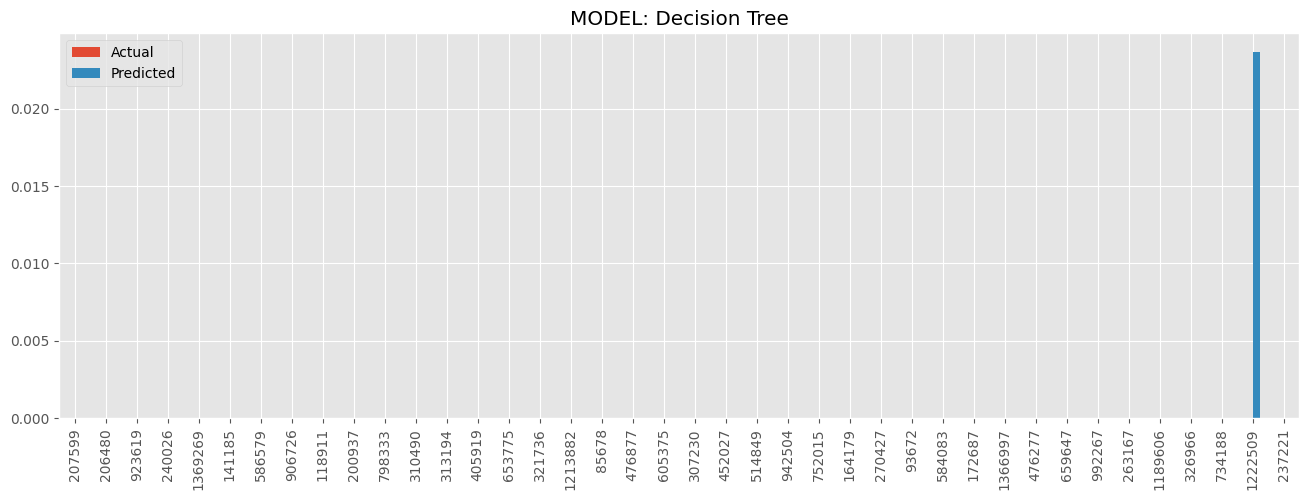

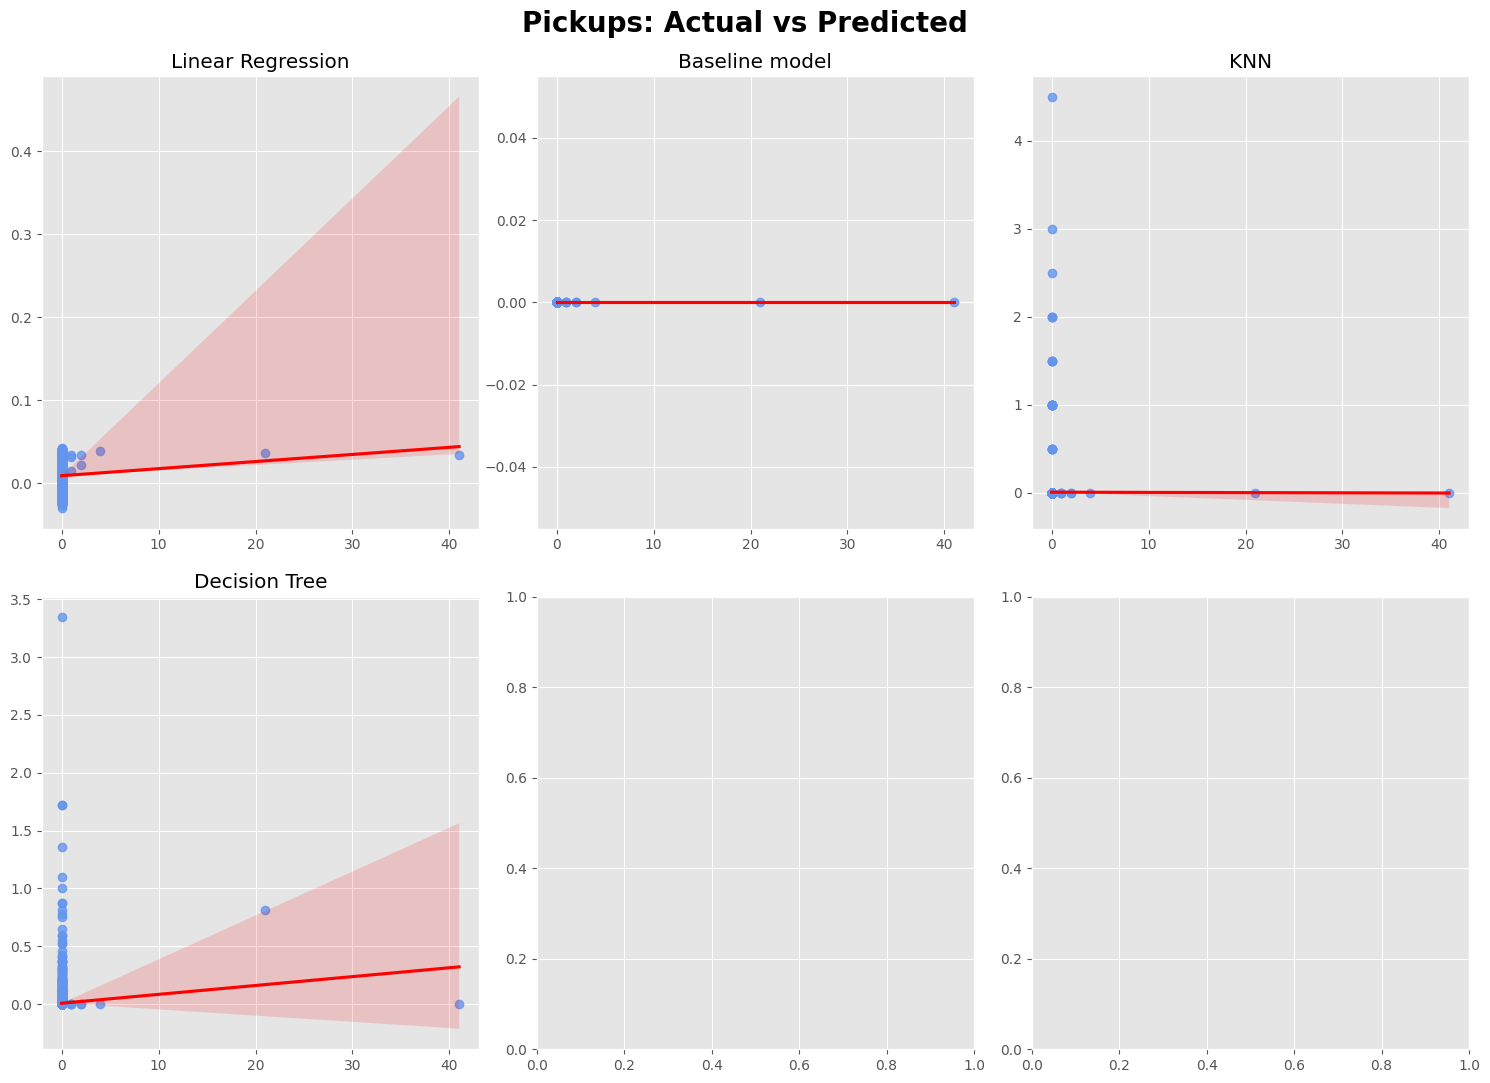

In [26]:
plot_real_vs_pred('Decision Tree', y_val, regd_y_pred)

fig, ax =plt.subplots(2,3,figsize=(15,11))
fig.suptitle('Pickups: Actual vs Predicted', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.92, hspace=0.15)

sns.regplot(x=y_val.head(5000), y=reg_y_pred[:5000],ax=ax[0,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression')
sns.regplot(x=y_val.head(5000), y=base_y_pred[:5000],  ax=ax[0,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline model')
sns.regplot(x=y_val.head(5000), y=regk_y_pred[:5000],  ax=ax[0,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN')
sns.regplot(x=y_val.head(5000), y=regd_y_pred[:5000],  ax=ax[1,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree')

for row in ax:
    for column in row:
        column.set_xlabel("")
        column.set_ylabel("")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MODEL:  Decision Tree
MAE:  0.016937559534773283
RMSE:  0.3204762910910722
R^2 (Coefficient of determination):  -0.032711009823678916
R (Correlation coefficient):  0.1146741634859241


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


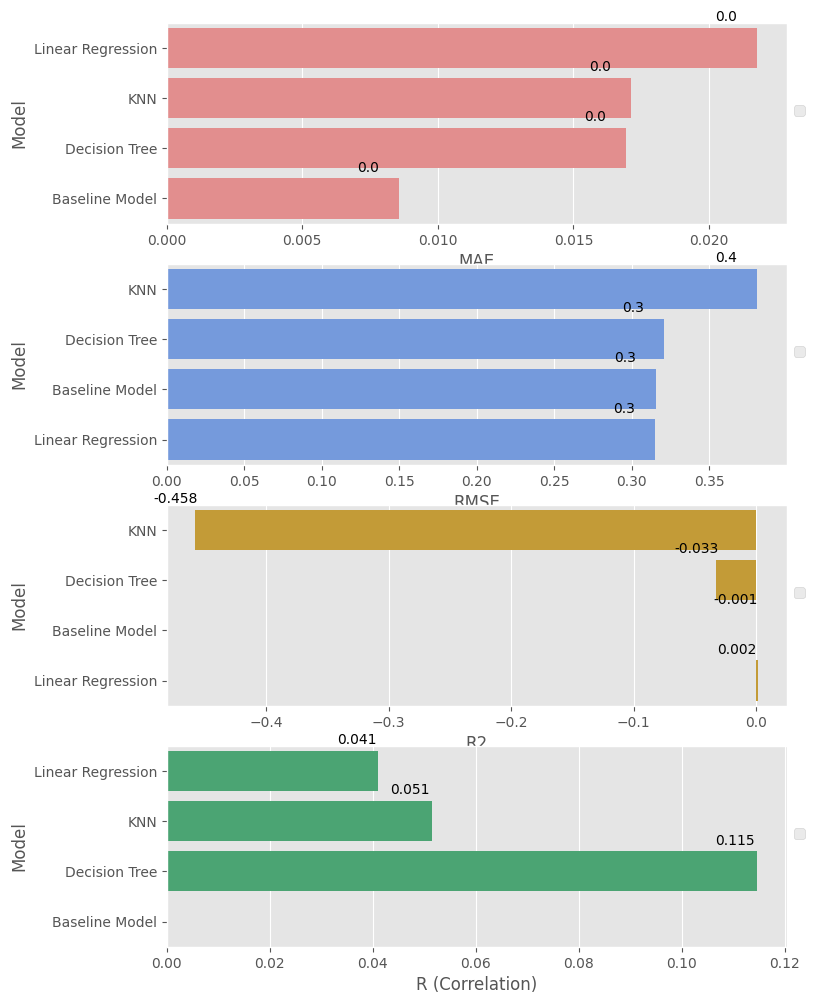

In [30]:
regd_metrics = get_metrics('Decision Tree', y_val, regd_y_pred)

compare_model_metrics([base_metrics,
                       reg_metrics,
                       regk_metrics,
                       regd_metrics])

In [31]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
regk_grid = GridSearchCV(KNeighborsRegressor(),
                       param_grid={"n_neighbors":np.arange(2,4),
                                  "leaf_size":np.arange(15,25)},
                       cv = 2,
                       scoring = "neg_mean_absolute_error")

# Train the model with the dataset
regk_grid.fit(X_train,y_train)

# Do predictions
regk_grid_y_pred = regk_grid.predict(X_val)
regk_grid.best_params_

CPU times: total: 10min 23s
Wall time: 13min 13s


{'leaf_size': 15, 'n_neighbors': 2}

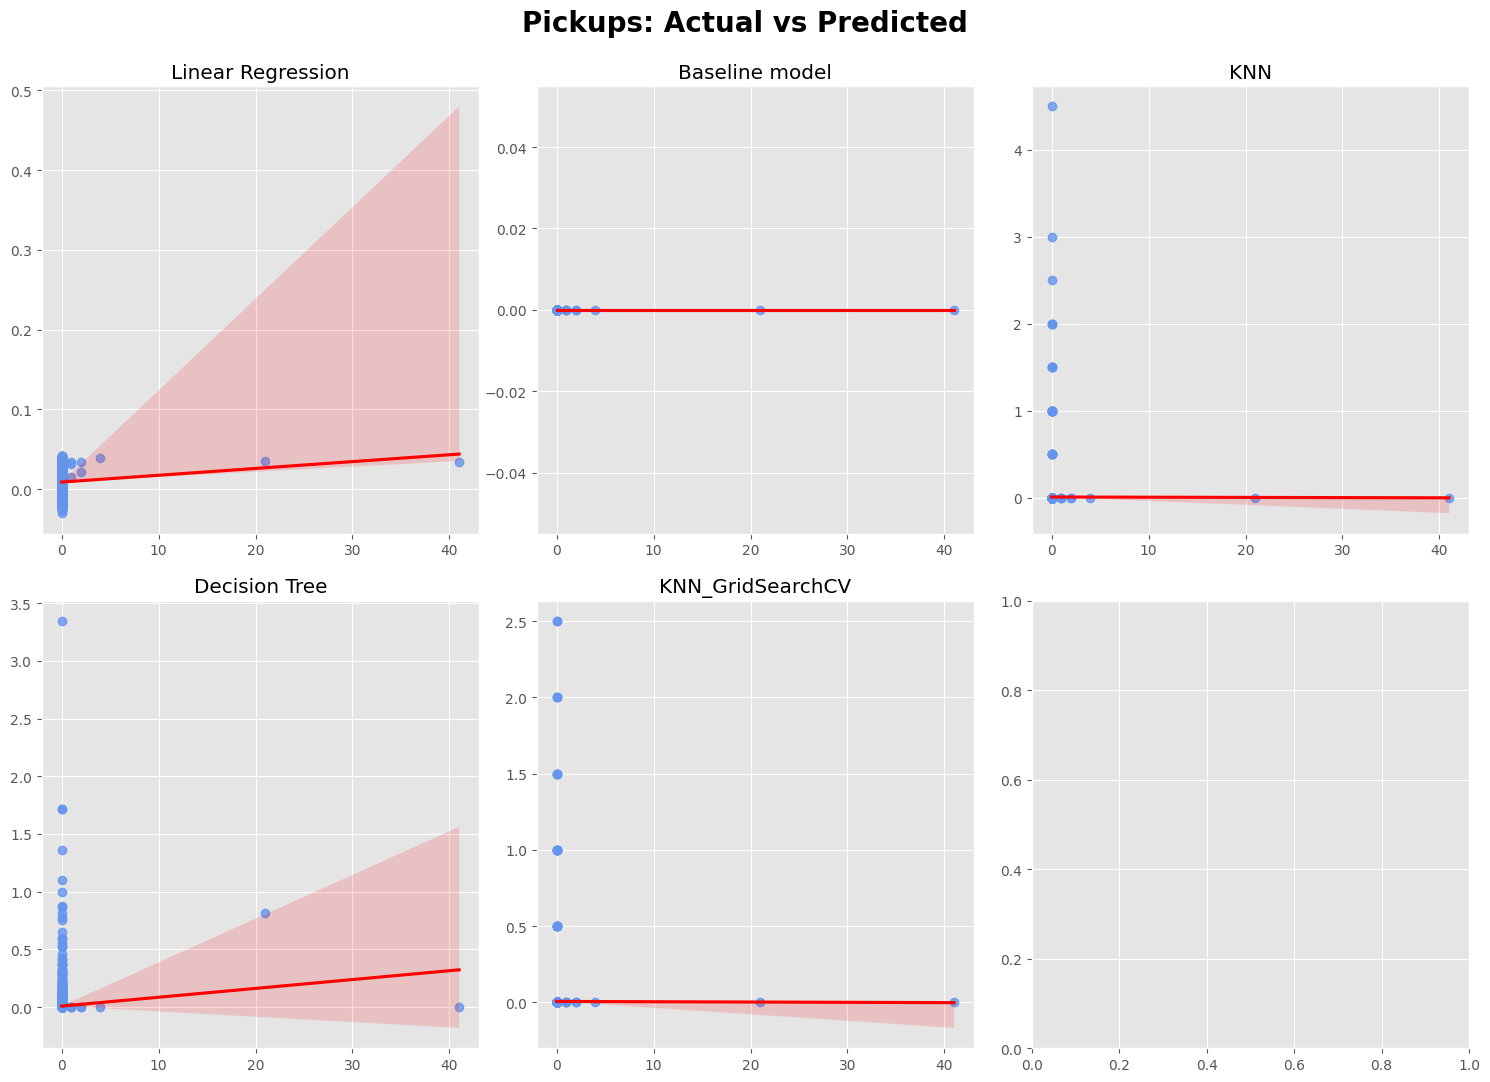

In [32]:
fig, ax =plt.subplots(2,3,figsize=(15,11))
fig.suptitle('Pickups: Actual vs Predicted', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.91, hspace=0.15)

sns.regplot(x=y_val.head(5000), y=reg_y_pred[:5000],ax=ax[0,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression')
sns.regplot(x=y_val.head(5000), y=base_y_pred[:5000],  ax=ax[0,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline model')
sns.regplot(x=y_val.head(5000), y=regk_y_pred[:5000],  ax=ax[0,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN')
sns.regplot(x=y_val.head(5000), y=regd_y_pred[:5000],  ax=ax[1,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree')
sns.regplot(x=y_val.head(5000), y=regk_grid_y_pred[:5000],  ax=ax[1,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_GridSearchCV')

for row in ax:
    for column in row:
        column.set_xlabel("")
        column.set_ylabel("")

MODEL:  KNN_GridSearchCV
MAE:  0.01725741037543008
RMSE:  0.39170366923071837
R^2 (Coefficient of determination):  -0.5427738712188932
R (Correlation coefficient):  0.019463434920747556


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


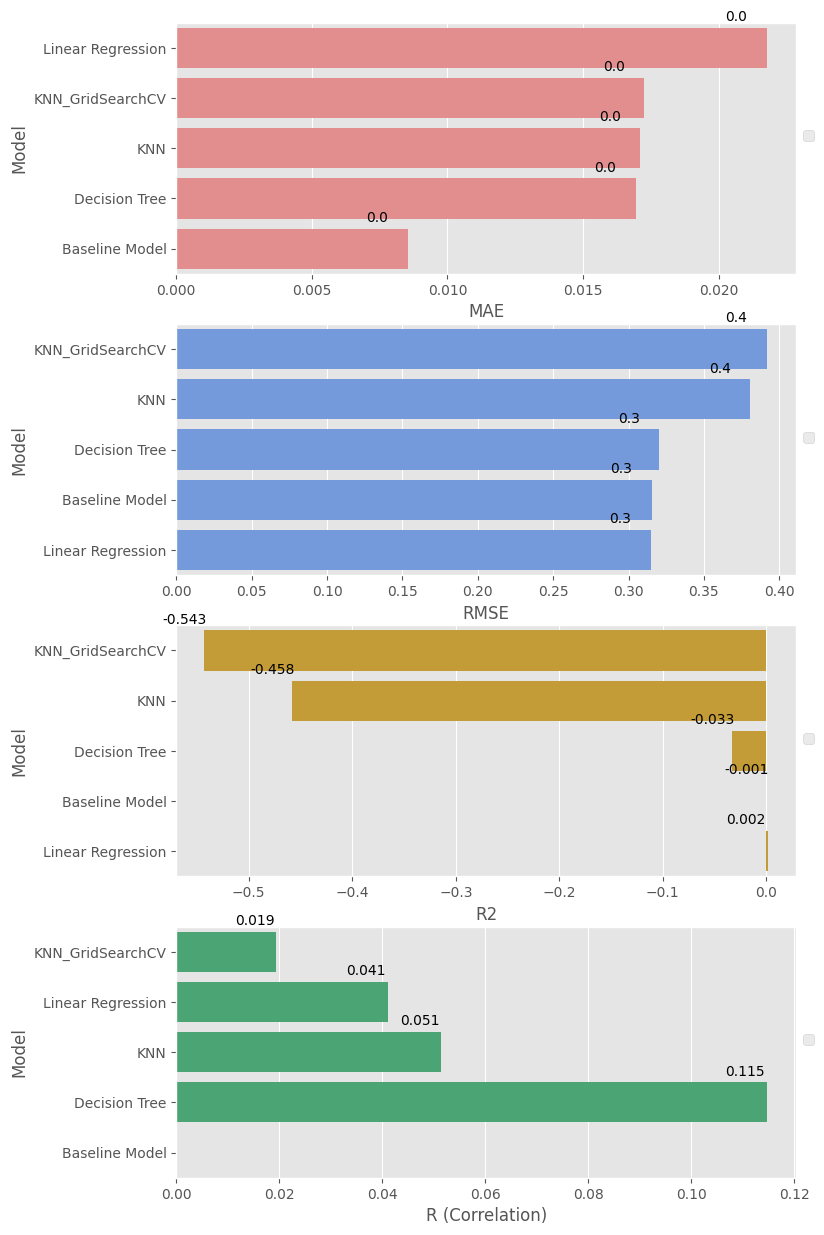

In [33]:
regk_grid_metrics = get_metrics('KNN_GridSearchCV', y_val, regk_grid_y_pred)

compare_model_metrics([base_metrics,
                       reg_metrics,
                       regk_metrics,
                       regd_metrics,
                       regk_grid_metrics])

In [34]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

regd_grid = GridSearchCV(DecisionTreeRegressor(),
                       param_grid={"max_depth":np.arange(25,35),
                                  "min_samples_leaf":np.arange(2,10)},
                       cv = 2,
                       scoring = "neg_mean_absolute_error")

# Train the model with the dataset
regd_grid.fit(X_train,y_train)

# Do predictions
regd_grid_y_pred = regd_grid.predict(X_val)
regd_grid.best_params_

CPU times: total: 3min 50s
Wall time: 4min 32s


{'max_depth': 25, 'min_samples_leaf': 4}

In [ ]:
fig, ax =plt.subplots(2,3,figsize=(15,11))
fig.suptitle('Pickups: Actual vs Predicted', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.91, hspace=0.15)

sns.regplot(x=y_val.head(5000), y=reg_y_pred[:5000],ax=ax[0,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression')
sns.regplot(x=y_val.head(5000), y=base_y_pred[:5000],  ax=ax[0,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline model')
sns.regplot(x=y_val.head(5000), y=regk_y_pred[:5000],  ax=ax[0,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN')
sns.regplot(x=y_val.head(5000), y=regd_y_pred[:5000],  ax=ax[1,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree')
sns.regplot(x=y_val.head(5000), y=regk_grid_y_pred[:5000],  ax=ax[1,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_GridSearchCV')
sns.regplot(x=y_val.head(5000), y=regd_grid_y_pred[:5000],  ax=ax[1,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree_GridSearchCV')

for row in ax:
    for column in row:
        column.set_xlabel("")
        column.set_ylabel("")

MODEL:  Decision Tree_GridSearchCV
MAE:  0.017406565754065594
RMSE:  0.336176365537863
R^2 (Coefficient of determination):  -0.13637416250936707
R (Correlation coefficient):  0.06833984394438547


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


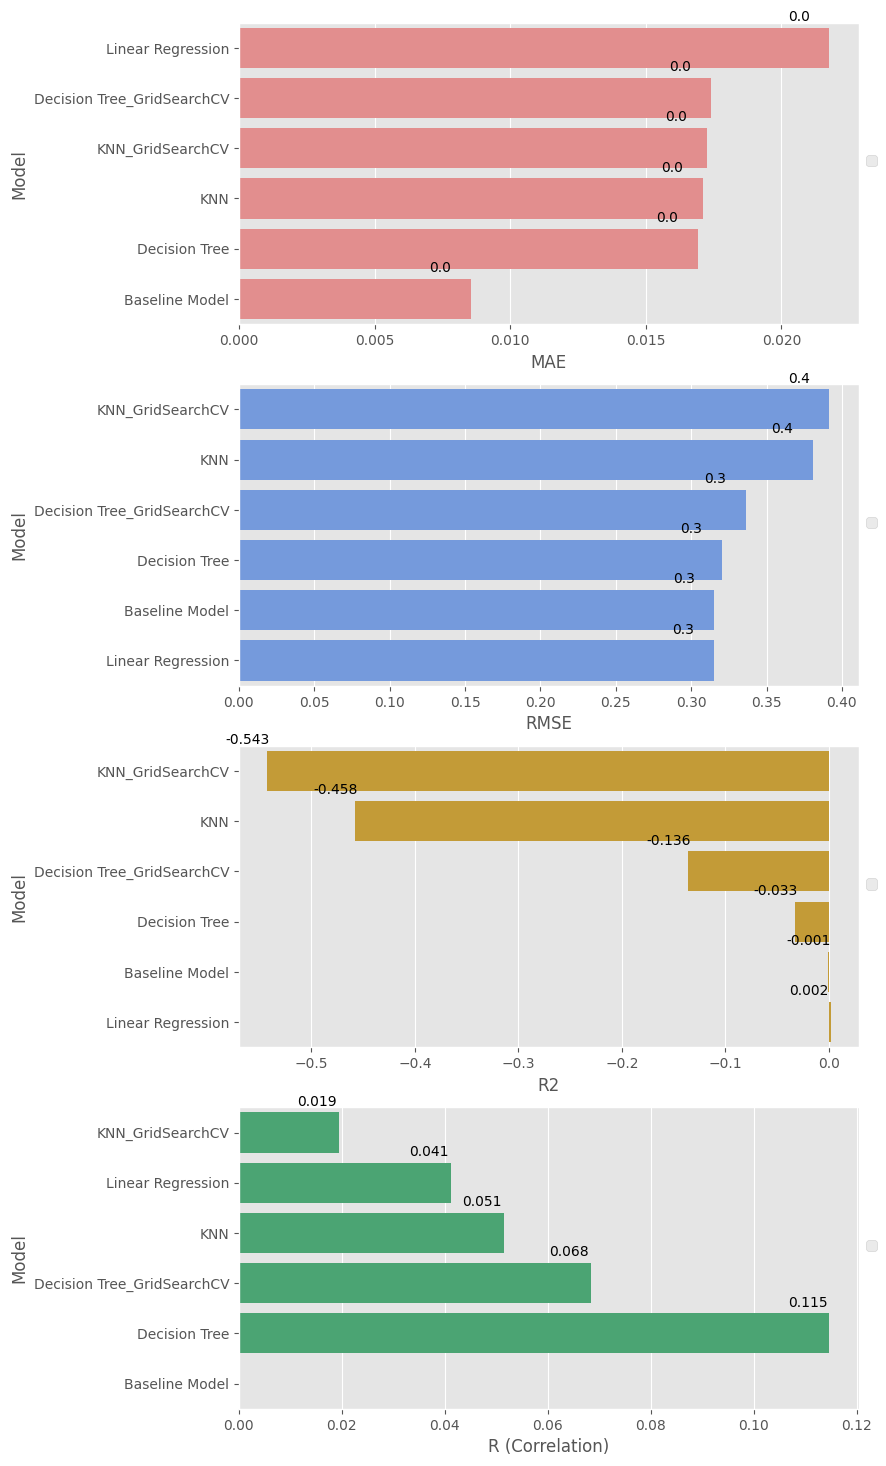

In [35]:
regd_grid_metrics = get_metrics('Decision Tree_GridSearchCV', y_val, regd_grid_y_pred)

compare_model_metrics([base_metrics,
                       reg_metrics,
                       regk_metrics,
                       regd_metrics,
                       regk_grid_metrics,
                       regd_grid_metrics])

In [36]:
%%time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

regk_bag=BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=3),
                          n_estimators=100,oob_score=False)

# Train the model
regk_bag.fit(X_train,y_train)

MemoryError: Unable to allocate 31.6 MiB for an array with shape (829209, 5) and data type float64

In [37]:
%%time
# Do predictions
regk_bag_y_pred = regk_bag.predict(X_val)

CPU times: total: 46.9 ms
Wall time: 139 ms


In [38]:
fig, ax =plt.subplots(3,3,figsize=(15,16))
fig.suptitle('Pickups: Actual vs Predicted', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.93, hspace=0.15)

sns.regplot(x=y_val.head(5000), y=reg_y_pred[:5000],ax=ax[0,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression')
sns.regplot(x=y_val.head(5000), y=base_y_pred[:5000],  ax=ax[0,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline: model')
sns.regplot(x=y_val.head(5000), y=regk_y_pred[:5000],  ax=ax[0,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN')
sns.regplot(x=y_val.head(5000), y=regd_y_pred[:5000],  ax=ax[1,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree')
sns.regplot(x=y_val.head(5000), y=regk_grid_y_pred[:5000],  ax=ax[1,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_GridSearchCV')
sns.regplot(x=y_val.head(5000), y=regd_grid_y_pred[:5000],  ax=ax[1,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree_GridSearchCV')
sns.regplot(x=y_val.head(5000), y=regk_bag_y_pred[:5000],  ax=ax[2,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_Bagging')

for row in ax:
    for column in row:
        column.set_xlabel("")
        column.set_ylabel("")

TypeError: 'float' object is not subscriptable

MemoryError: In RendererAgg: Out of memory

<Figure size 1500x1600 with 9 Axes>

In [ ]:
regk_bag_metrics = get_metrics('KNN_Bagging', y_val, regk_bag_y_pred)

compare_model_metrics([base_metrics,
                       reg_metrics,
                       regk_metrics,
                       regd_metrics,
                       regk_grid_metrics,
                       regd_grid_metrics,
                       regk_bag_metrics])

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor

# n_jobs: to specify how many concurrent processes/threads should be used. For -1, all CPUs are used.
regrf = RandomForestRegressor(max_depth=31,
                              min_samples_leaf=5,
                              n_estimators=50,
                              n_jobs=-1)
                            
# Train the mdoel
regrf.fit(X_train,y_train)

# Do predictions
regrf_y_pred = regrf.predict(X_val)

In [ ]:
fig, ax =plt.subplots(3,3,figsize=(15,16))
fig.suptitle('Pickups: Actual vs Predicted', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.93, hspace=0.15)

sns.regplot(x=y_val.head(5000), y=reg_y_pred[:5000],ax=ax[0,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression')
sns.regplot(x=y_val.head(5000), y=base_y_pred[:5000],  ax=ax[0,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline model')
sns.regplot(x=y_val.head(5000), y=regk_y_pred[:5000],  ax=ax[0,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN')
sns.regplot(x=y_val.head(5000), y=regd_y_pred[:5000],  ax=ax[1,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree')
sns.regplot(x=y_val.head(5000), y=regk_grid_y_pred[:5000],  ax=ax[1,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_GridSearchCV')
sns.regplot(x=y_val.head(5000), y=regd_grid_y_pred[:5000],  ax=ax[1,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree_GridSearchCV')
sns.regplot(x=y_val.head(5000), y=regk_bag_y_pred[:5000],  ax=ax[2,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_Bagging')
sns.regplot(x=y_val.head(5000), y=regrf_y_pred[:5000],  ax=ax[2,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Random Forest')

for row in ax:
    for column in row:
        column.set_xlabel("")
        column.set_ylabel("")

In [ ]:
regrf_metrics = get_metrics('Random Forest', y_val, regrf_y_pred)

compare_model_metrics([base_metrics,
                       reg_metrics,
                       regk_metrics,
                       regd_metrics,
                       regk_grid_metrics,
                       regd_grid_metrics,
                       regk_bag_metrics,
                       regrf_metrics])

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


regrf_rscv= RandomizedSearchCV(RandomForestRegressor(),
                       param_distributions={"max_depth":np.arange(25,35),
                                  "min_samples_leaf":np.arange(2,10),
                                  "n_estimators": (10,50,100,500)},
                       cv = 2,
                       scoring = "neg_mean_absolute_error",
                       n_iter=5)

# Train the model with the dataset
regrf_rscv.fit(X_train,y_train)

In [ ]:
%%time
# Do predictions
regrf_rscv_y_pred = regrf_rscv.predict(X_val)
regrf_rscv.best_estimator_

In [ ]:
fig, ax =plt.subplots(3,3,figsize=(15,16))
fig.suptitle('Pickups: Actual vs Predicted', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.93, hspace=0.15)

sns.regplot(x=y_val.head(5000), y=reg_y_pred[:5000],ax=ax[0,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression')
sns.regplot(x=y_val.head(5000), y=base_y_pred[:5000],  ax=ax[0,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline model')
sns.regplot(x=y_val.head(5000), y=regk_y_pred[:5000],  ax=ax[0,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN')
sns.regplot(x=y_val.head(5000), y=regd_y_pred[:5000],  ax=ax[1,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree')
sns.regplot(x=y_val.head(5000), y=regk_grid_y_pred[:5000],  ax=ax[1,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_GridSearchCV')
sns.regplot(x=y_val.head(5000), y=regd_grid_y_pred[:5000],  ax=ax[1,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree_GridSearchCV')
sns.regplot(x=y_val.head(5000), y=regk_bag_y_pred[:5000],  ax=ax[2,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_Bagging')
sns.regplot(x=y_val.head(5000), y=regrf_y_pred[:5000],  ax=ax[2,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Random Forest')
sns.regplot(x=y_val.head(5000), y=regrf_rscv_y_pred[:5000],  ax=ax[2,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Random Forest_RandomGrid')

for row in ax:
    for column in row:
        column.set_xlabel("")
        column.set_ylabel("")

In [ ]:
regrf_rscv_metrics = get_metrics('Random Forest_RandomizedSearchCV',
                                 y_val, regrf_rscv_y_pred)

compare_model_metrics([base_metrics,
                       reg_metrics,
                       regk_metrics,
                       regd_metrics,
                       regk_grid_metrics,
                       regd_grid_metrics,
                       regk_bag_metrics,
                       regrf_metrics,
                       regrf_rscv_metrics])

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

regGB = GradientBoostingRegressor(max_depth=10,
                                min_samples_leaf=3,
                                n_estimators=200,
                                learning_rate=0.1)

# Train the model
regGB.fit(X_train,y_train)

In [ ]:
# Do predictions
regGB_y_pred = regGB.predict(X_val)

In [ ]:
fig, ax =plt.subplots(4,3,figsize=(15,22))
fig.suptitle('Pickups: Actual vs Predicted', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.95, hspace=0.15)

sns.regplot(x=y_val.head(5000), y=reg_y_pred[:5000],ax=ax[0,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression')
sns.regplot(x=y_val.head(5000), y=base_y_pred[:5000],  ax=ax[0,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline model')
sns.regplot(x=y_val.head(5000), y=regk_y_pred[:5000],  ax=ax[0,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN')
sns.regplot(x=y_val.head(5000), y=regd_y_pred[:5000],  ax=ax[1,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree')
sns.regplot(x=y_val.head(5000), y=regk_grid_y_pred[:5000],  ax=ax[1,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_GridSearchCV')
sns.regplot(x=y_val.head(5000), y=regd_grid_y_pred[:5000],  ax=ax[1,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision Tree_GridSearchCV')
sns.regplot(x=y_val.head(5000), y=regk_bag_y_pred[:5000],  ax=ax[2,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN_Bagging: Actual vs Pred')
sns.regplot(x=y_val.head(5000), y=regrf_y_pred[:5000],  ax=ax[2,1],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Random Forest')
sns.regplot(x=y_val.head(5000), y=regrf_rscv_y_pred[:5000],  ax=ax[2,2],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Random Forest_RandomGrid')
sns.regplot(x=y_val.head(5000), y=regGB_y_pred[:5000],  ax=ax[3,0],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Gradient Boosting')

for row in ax:
    for column in row:
        column.set_xlabel("")
        column.set_ylabel("")

In [ ]:
regGB_metrics = get_metrics('Gradient Boosting',
                            y_val, regGB_y_pred)

compare_model_metrics([base_metrics,
                       reg_metrics,
                       regk_metrics,
                       regd_metrics,
                       regk_grid_metrics,
                       regd_grid_metrics,
                       regk_bag_metrics,
                       regrf_metrics,
                       regrf_rscv_metrics,
                       regGB_metrics])

In [ ]:
# Obtener Predicciones de Validación y Test
regGB_y_pred_VAL = regGB.predict(X_val)
regGB_y_pred_TEST = regGB.predict(X_test)

# Graficar Actual vs Predicciones de Test y Actual vs Predicciones de Validación
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Modelo de Gradient Boosting: Real vs Pronosticado', fontsize=16, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.85, wspace=0.2)

sns.regplot(x=y_val.head(5000), y=regGB_y_pred_VAL[:5000], ax=ax[0],
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
   .set_title('Validación')

sns.regplot(x=y_test.head(5000), y=regGB_y_pred_TEST[:5000], ax=ax[1],
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
   .set_title('Test')

ax[0].set_xlabel("Real")
ax[0].set_ylabel("Pronosticado")
ax[1].set_xlabel("Real")
ax[1].set_ylabel("Pronosticado")


In [ ]:
# Obtener Métricas de Validación y Test
regGB_metrics_VAL = get_metrics('Gradient Boosting_VAL',
                                y_val, regGB_y_pred_VAL)
regGB_metrics_TEST = get_metrics('Gradient Boosting_TEST',
                                 y_test, regGB_y_pred_TEST)

# Comparar métricas
compare_model_metrics([regGB_metrics_VAL,
                       regGB_metrics_TEST])

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

residuales_val = y_val - regGB_y_pred_VAL 
residuales_test = y_test - regGB_y_pred_TEST 

# Imprimir estadísticas descriptivas
print('Media de Residuales en Validación: ', residuales_val.mean())
print('Media de Residuales en Test: ', residuales_test.mean())

# Graficar Valores Ajustados vs Residuales para Validación y Test
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Modelo de Gradient Boosting: Valores Ajustados vs Residuales', fontsize=16, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.85, wspace=0.2)

suavizado_val = lowess(residuales_val, y_val)
suavizado_test = lowess(residuales_test, y_val)
ax[0].plot(suavizado_val[:, 0], suavizado_val[:, 1], color='r')
ax[1].plot(suavizado_test[:, 0], suavizado_test[:, 1], color='r')

sns.regplot(x=y_val.head(5000), y=residuales_val[:5000], ax=ax[0], fit_reg=False,
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
    .set_title('Validación')
sns.regplot(x=y_test.head(5000), y=residuales_test[:5000], ax=ax[1], fit_reg=False,
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
    .set_title('Test')

ax[0].set_xlabel("Valores Ajustados")
ax[0].set_ylabel("Residuales")
ax[1].set_xlabel("Valores Ajustados")
ax[1].set_ylabel("Residuales")


In [ ]:
import pickle
pickle.dump(regGB,open('./model_regGB_origen.pickle','wb'))